In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [40]:
# plot series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Year")
    plt.ylabel("Number of sunspots")
    plt.grid(True)

In [41]:
import csv
from datetime import datetime
time_step = []
sunspots = []

with open('C:/Users/domin/Desktop/misia/studia/VI semestr/biai/Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        time_step.append(datetime.strptime(row[1], '%Y-%m-%d'))
        sunspots.append(float(row[2]))

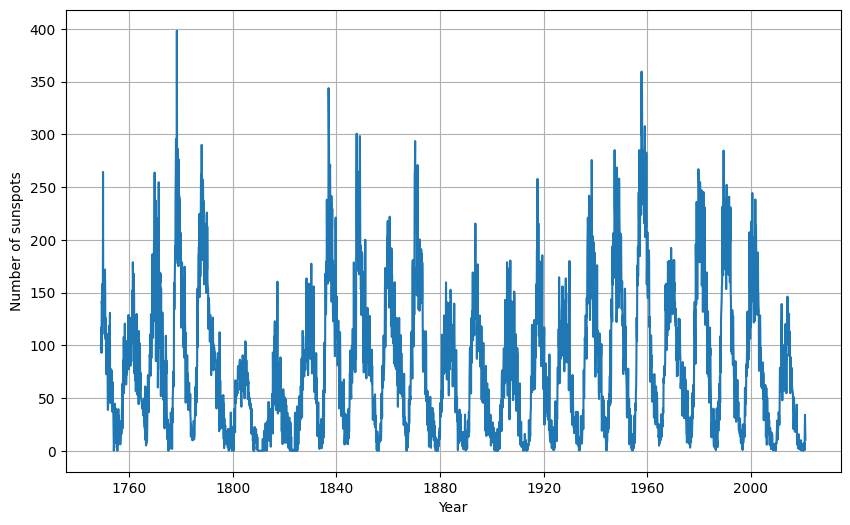

In [42]:
series = np.array(sunspots)
time = np.array(time_step)

plt.figure(figsize=(10,6))
plot_series(time, series)

In [43]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [44]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w : (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [45]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w : w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [46]:
# Hyperparameters
window_size = 60
batch_size = 100
shuffle_buffer_size = 1000

In [49]:
def test_data_pipeline(series):
    series = np.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(60, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(60))
    data = data.batch(1).prefetch(1)
    return data

In [50]:
# Predicting on the same dataset
test = test_data_pipeline(series)
forecast = model.predict(test)
forecast = forecast[:, -1, 0]

3206/3206 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step


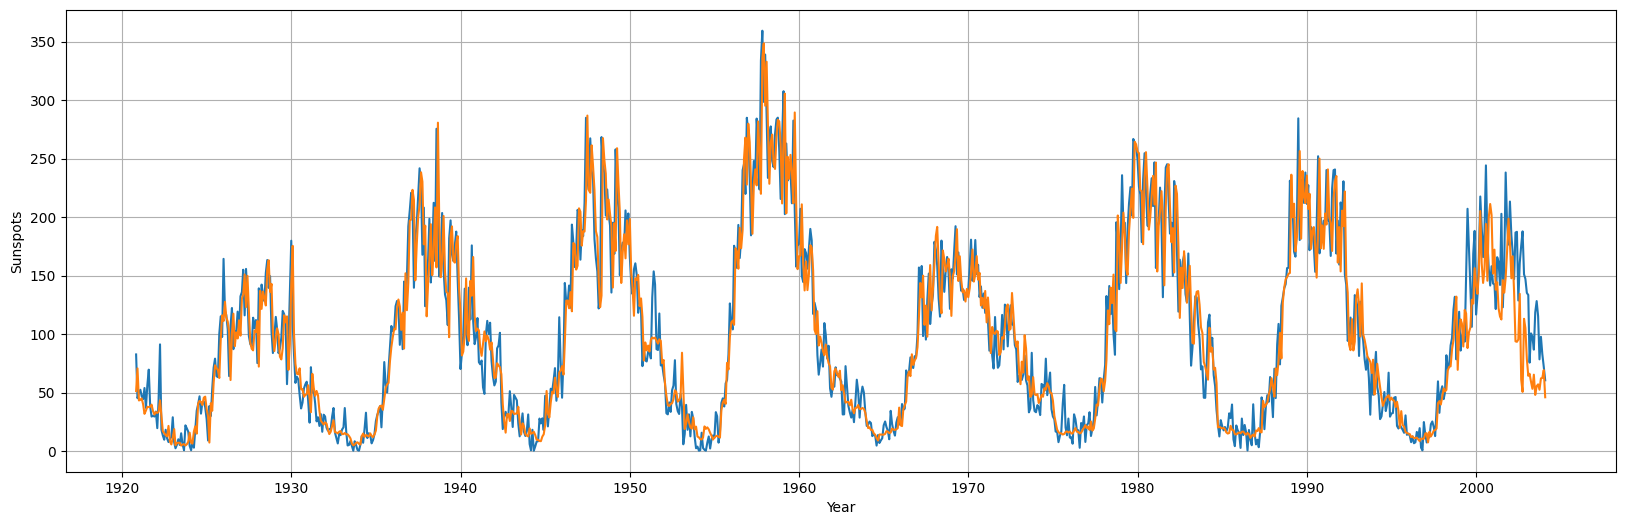

In [58]:
# The function to plot series data
def plotter(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Year")
    plt.ylabel("Sunspots")
    plt.grid(True)

# Forecasting sunspots using the trained model
time_valid = time[window_size+1:]
series_ori = series[window_size+1:]
forecast = np.reshape(forecast, (-1))
forecast = forecast[:-1]
plt.figure(figsize=(20, 6))
plotter(time_valid[2000:3000], series_ori[2000:3000])
plotter(time_valid[2000:3000], forecast[2000:3000])

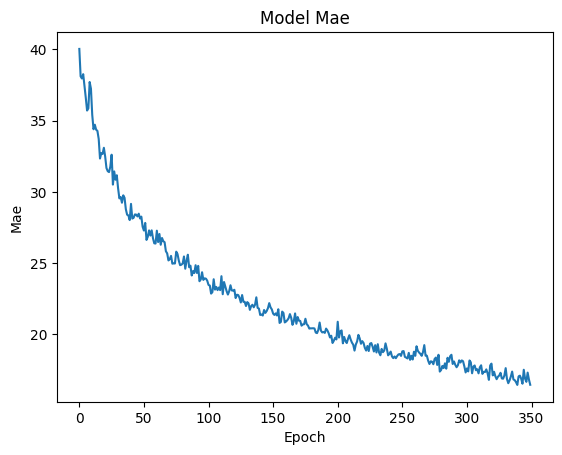

In [41]:
# Plotting mae values - mean absolute error
plt.plot(history.history['mae'][50:])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.show()

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()


30.602255

In [51]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

In [25]:
#Załaduj dane MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [33]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [52]:
def create_model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=60,
                           kernel_size=5,
                          strides=1,
                          padding='causal',
                          activation='relu',
                          input_shape= [None, 1]),
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60, return_sequences=True),
    #tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
    #tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])
    return model

In [62]:
epochs_list = [100, 400, 2000, 4000, 6000, 8000]

In [63]:
results = {}

for epochs in epochs_list:
    print(f'Training model for {epochs} epochs...')
    model = create_model()
    train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
    history = model.fit(train_set, epochs=epochs, verbose=2)

# Save mae
    mae_list = history.history['mae']

    # Forecast on the same dataset
    test = test_data_pipeline(series)
    forecast = model.predict(test)
    forecast = forecast[:, -1, 0]
# Save forecast
    forecast_list = forecast.tolist()

    results[epochs] = {'mae': mae_list, 'forecast': forecast_list}

# Save results
np.save('C:/Users/dominika/Desktop/training_results_sunspots.npy', results)
print('Results saved to C:/Users/dominika/Desktop/training_results_sunspots.npy')

Training model for 8000 epochs...
Epoch 1/8000
30/30 - 6s - 198ms/step - loss: 82.2230 - mae: 82.7112
Epoch 2/8000
30/30 - 3s - 85ms/step - loss: 81.4210 - mae: 81.9167
Epoch 3/8000
30/30 - 2s - 83ms/step - loss: 80.1825 - mae: 80.6797
Epoch 4/8000
30/30 - 3s - 87ms/step - loss: 77.4570 - mae: 77.9536
Epoch 5/8000
30/30 - 3s - 90ms/step - loss: 70.5686 - mae: 71.0655
Epoch 6/8000
30/30 - 2s - 81ms/step - loss: 59.1141 - mae: 59.6122
Epoch 7/8000
30/30 - 2s - 83ms/step - loss: 54.5393 - mae: 55.0375
Epoch 8/8000
30/30 - 3s - 84ms/step - loss: 54.5661 - mae: 55.0646
Epoch 9/8000
30/30 - 3s - 84ms/step - loss: 54.2410 - mae: 54.7396
Epoch 10/8000
30/30 - 2s - 82ms/step - loss: 53.9158 - mae: 54.4141
Epoch 11/8000
30/30 - 3s - 83ms/step - loss: 52.9174 - mae: 53.4159
Epoch 12/8000
30/30 - 2s - 81ms/step - loss: 50.7606 - mae: 51.2585
Epoch 13/8000
30/30 - 2s - 82ms/step - loss: 51.5368 - mae: 52.0353
Epoch 14/8000
30/30 - 2s - 81ms/step - loss: 51.2435 - mae: 51.7415
Epoch 15/8000
30/30 - 

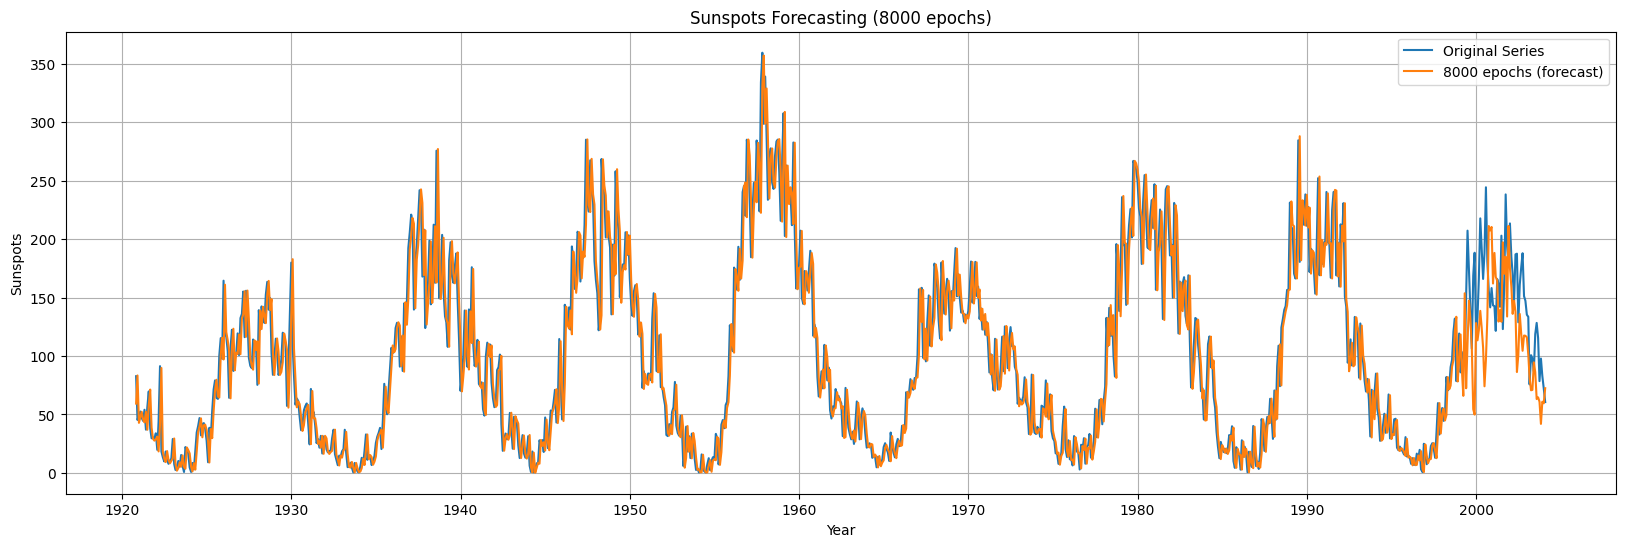

In [64]:
# The function to plot series data
def plotter(time, series, format="-", label=None, start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Year")
    plt.ylabel("Sunspots")
    plt.grid(True)

# Loop over each epoch's result and plot the forecast
for epochs, data in results.items():
    forecast = np.array(data['forecast'])
    forecast = np.reshape(forecast, (-1))
    forecast = forecast[:-1]  # Trim the forecast if necessary
    
    plt.figure(figsize=(20, 6))
    
    # Plot the original series
    plotter(time_valid[2000:3000], series_ori[2000:3000], label="Original Series")
    
    # Plot the forecast series
    plotter(time_valid[2000:3000], forecast[2000:3000], format="-", label=f"{epochs} epochs (forecast)")
    
    # Add title and legend
    plt.title(f'Sunspots Forecasting ({epochs} epochs)')
    plt.legend()
    plt.show()